In [1]:
import numpy as np
import pingouin as pg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import correlation
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay, make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, ShuffleSplit
import xarray as xr

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
def custom_corr(y, y_pred):
    corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
    return corr

In [5]:
corr_scorer = make_scorer(custom_corr)
mape_scorer = make_scorer(mean_absolute_percentage_error)

In [6]:
dataset_name = "abcd"
domain = "psy"
dataset_path = f"data/{dataset_name}_400parcels.nc"

In [7]:
dataset = xr.open_dataset(dataset_path)

In [8]:
mode = "shuffle"
prediction_type = "multivar"

if mode =="cv":
    exp_name = f"5foldcv_redmat_enc_{dataset_name}_{prediction_type}_{domain}"
else:
    exp_name = f"shuffle_redmat_enc_{dataset_name}_{prediction_type}_{domain}"
    
root = '.'
exp_dir = f"{root}/results/{exp_name}"

### Corr Across folds and targets

In [9]:
target_dict_hcp = {
    "PicVocab_AgeAdj": "NIHTB Vocabulary (picture matching)",
    "ReadEng_AgeAdj": "NIHTB Reading (pronunciation)",
    "WM_Task_2bk_Acc": "Working Memory (2-back)",
    "Relational_Task_Acc": "Relational processing",
    "Language_Task_Story_Acc": "Story comprehension",
    "PMAT24_A_CR": "Fluid Intelligence (PMAT)",
    "VSPLOT_TC": "Spatial orientation",  #???
    "CardSort_AgeAdj": "NIHTB Cognitive Flexibility (DCCS)",
    "PMAT24_A_CR": "Fluid Intelligence (Penn Progressive Matrices)",
    "ProcSpeed_AgeAdj": "NIHTB Processing Speed",
    "CogFluidComp_AgeAdj":"NIHTB Cognition Fluid",
    "CogTotalComp_AgeAdj":"NIHTB Cognition Total",
    "CogCrystalComp_AgeAdj":"NIHTB Cognition Crystallized",
    "ListSort_AgeAdj": "NIHTB Working Memory (list sorting)",
    "Language_Task_Math_Acc": "Arithmetic", # ???
    "PicSeq_AgeAdj": "NIHTB Visual Episodic Memory",
    "SCPT_SPEC": "Sustained attention (Spec.)",
    "Flanker_AgeAdj": "NIHTB Inhibition (Flanker Task)",

    "AngAffect_Unadj": "NIHTB Anger",
    "AngHostil_Unadj": "NIHTB Hostility & Cynicism",
    "AngAggr_Unadj": "NIHTB Physical Aggression",
    "FearAffect_Unadj": "NIHTB Fear",
    "FearSomat_Unadj": "NIHTB Somatic Arousal",
    "Sadness_Unadj": "NIHTB Sadness",
    "LifeSatisf_Unadj": "NIHTB Life Satisfaction",
    "MeanPurp_Unadj": "NIHTB Meaning and Purpose",
    "PosAffect_Unadj": "NIHTB Positive Affect",
    "Friendship_Unadj": "NIHTB Friendship",
    "Loneliness_Unadj": "NIHTB Loneliness",
    "PercHostil_Unadj": "NIHTB Perceived Hostility",
    "PercReject_Unadj": "NIHTB Perceived Rejection",
    "EmotSupp_Unadj": "NIHTB Emotional Support",
    "InstruSupp_Unadj": "NIHTB Instrumental Support",
    "PercStress_Unadj": "NIHTB Perceived Stress",
    "SelfEff_Unadj": "NIHTB Self-Efficacy",
    
    "Emotion_Task_Face_Acc": "Emotional Face Matching",
    "IWRD_TOT": "Verbal Episodic Memory",
    "Dexterity_AgeAdj": "Manual dexterity",
    "ER40_CR": "Emotion recognition - Total",
    "ER40SAD": "Emotion recognition - Sad",
    "ER40ANG": "Emotion recognition - Angry",
    ### SOCIAL COGNITION - INTERACTION ??????
    "ER40NOE": "Emotion recognition - Neutral",
    "MMSE_Score": "Cognitive status (MMSE)",
    "ER40HAP": "Emotion recognition - Happy",
    "SCPT_SEN": "Sustained attention (Sens.)",
    "Social_Task_Perc_Random": "Social cognition (Random)",
    "ER40FEAR": "Emotion recognition - Fear"
}

target_dict_abcd = {
    'cbcl_scr_syn_anxdep_r': 'CBCL Anxiety/Depression',
    'cbcl_scr_syn_anxdep_t': 'CBCL Anxiety/Depression',
    'cbcl_scr_syn_withdep_r': 'CBCL Withdrawn/Depressed',
    'cbcl_scr_syn_withdep_t': 'CBCL Withdrawn/Depressed',
    'cbcl_scr_syn_somatic_r': 'CBCL Somatic Complaints',
    'cbcl_scr_syn_somatic_t': 'CBCL Somatic Complaints',
    'cbcl_scr_syn_social_r': 'CBCL Social Problems',
    'cbcl_scr_syn_social_t': 'CBCL Social Problems',
    'cbcl_scr_syn_thought_r': 'CBCL Thought Problems',
    'cbcl_scr_syn_thought_t': 'CBCL Thought Problems',
    'cbcl_scr_syn_attention_r': 'CBCL Attention Problems',
    'cbcl_scr_syn_attention_t': 'CBCL Attention Problems',
    'cbcl_scr_syn_rulebreak_r': 'CBCL Rule-Breaking Behavior',
    'cbcl_scr_syn_rulebreak_t': 'CBCL Rule-Breaking Behavior',   
    'cbcl_scr_syn_aggressive_r': 'CBCL Aggressive Behavior',
    'cbcl_scr_syn_aggressive_t': 'CBCL Aggressive Behavior',
    'cbcl_scr_syn_internal_r': 'CBCL Internalizing Problems',
    'cbcl_scr_syn_internal_t': 'CBCL Internalizing Problems',
    'cbcl_scr_syn_external_r': 'CBCL Externalizing Problems',
    'cbcl_scr_syn_external_t': 'CBCL Externalizing Problems',
    'cbcl_scr_syn_totprob_r': 'CBCL Total Problems',
    'cbcl_scr_syn_totprob_t': 'CBCL Total Problems',
    'cbcl_scr_07_sct_r': 'CBCL Social Competence',
    'cbcl_scr_07_sct_t': 'CBCL Social Competence',
    'cbcl_scr_07_ocd_r': 'CBCL Obsessive-Compulsive Disorder',
    'cbcl_scr_07_ocd_t': 'CBCL Obsessive-Compulsive Disorder',
    'cbcl_scr_07_stress_r': 'CBCL Stress, raw value',
    'cbcl_scr_07_stress_t': 'CBCL Stress, t value',
    'nihtbx_picvocab_uncorrected': "Vocabulary (picture matching), uncorrected",
    'nihtbx_flanker_uncorrected': "Inhibition (Flanker Task), uncorrected",
    'nihtbx_list_uncorrected': "Working Memory (list sorting), uncorrected",
    'nihtbx_cardsort_uncorrected': "Cognitive Flexibility (DCCS), uncorrected",
    'nihtbx_pattern_uncorrected': "Processing Speed, uncorrected",
    'nihtbx_reading_uncorrected': "Reading (pronunciation), uncorrected",
    'nihtbx_fluidcomp_uncorrected': "Cognition Fluid Composite Score, uncorrected",
    'nihtbx_cryst_uncorrected': "Cognition Crystallized Composite Score, uncorrected",
    'nihtbx_totalcomp_uncorrected': "Cognition Total Composite Score, uncorrected",
    'pea_wiscv_trs': "WISC-V Total Raw Score",
    'pea_wiscv_tss': "WISC-V Total Score",
    'nihtbx_picvocab_agecorrected': "NIHTB Vocabulary (picture matching)",
    'nihtbx_flanker_agecorrected': "NIHTB Inhibition (Flanker Task)",
    'nihtbx_list_agecorrected': "NIHTB Working Memory (list sorting)",
    'nihtbx_cardsort_agecorrected': "NIHTB Cognitive Flexibility (DCCS)",
    'nihtbx_pattern_agecorrected': "NIHTB Processing Speed",
    'nihtbx_picture_agecorrected': "NIHTB Visual Episodic Memory",
    'nihtbx_reading_agecorrected': "NIHTB Reading (pronunciation)",
    'nihtbx_fluidcomp_agecorrected': "NIHTB Cognition Fluid",
    'nihtbx_cryst_agecorrected': "NIHTB Cognition Crystallized",
    'nihtbx_totalcomp_agecorrected': "NIHTB Cognition Total",
    'nihtbx_picture_uncorrected': "NIHTB Visual Episodic Memory, uncorrected",
}

In [10]:
if dataset_name == "abcd":
    target_dict = target_dict_abcd
elif dataset_name == "hcp":
    target_dict = target_dict_hcp

In [231]:
predictions = pd.read_csv(f'{exp_dir}/pred_results.csv')

In [232]:
def fit_estimator(X_train, X_test, predictions_df, target, target_dict,run_type, run_id, train_ratio, model="ridge", save_pred=False):

    if run_type == "run":
        test_type = "validation"
    else:
        test_type = "test"

    target_run_perf = {}
    
    y_train = predictions_df[(predictions_df["dataset"] == "train") & (predictions_df["train_ratio"] == train_ratio) & (predictions_df[run_type] == run_id)][target].values
    y_test = predictions_df[(predictions_df["dataset"] == test_type) & (predictions_df["train_ratio"] == train_ratio) & (predictions_df[run_type] == run_id)][target].values
    
    if model == "ridge":
        estimator = Ridge(alpha=1.0)
    elif model == "krr":
        estimator = KernelRidge()
        estimator = GridSearchCV(
                    estimator=estimator, param_grid={
                        "alpha": [0, 1e-5, 1e-3, 1e-3, 4e-3, 7e-3, 1, 1.5, 2, 4, 5, 10, 15, 20],
                        "kernel": ['linear', 'rbf'],
                        
                    },
                )
    fitted_estimator = estimator.fit(X_train, y_train)
    y_train_pred = fitted_estimator.predict(X_train)
    y_test_pred = fitted_estimator.predict(X_test)

    if save_pred:
        np.save(f"{exp_dir}/ridge_y_pred_{target}_{run_type}{run_id}_train_ratio{train_ratio}_train.npy", y_train_pred)
        np.save(f"{exp_dir}/ridge_y_pred_{target}_{run_type}{run_id}_train_ratio{train_ratio}_{test_type}.npy", y_test_pred)

    train_corr = custom_corr(y_train, y_train_pred)
    test_corr = custom_corr(y_test, y_test_pred)

    target_run_perf["target"] = target_dict[target]
    target_run_perf["train_corr"] = train_corr
    target_run_perf["test_corr"] = test_corr
    target_run_perf["median_train_mape"] = np.median(100*np.abs(y_train-y_train_pred)/y_train)
    target_run_perf["median_test_mape"] = np.median(100*np.abs(y_test-y_test_pred)/y_test)
    target_run_perf["train_ratio"] = train_ratio
    target_run_perf[run_type] = run_id

    return target_run_perf

In [233]:
if mode == "cv":
    test_type = "validation"
    run_type = "fold"
    runs = np.arange(5)
else:
    test_type = "test"
    run_type = "seed"
    runs = [1001, 42, 54, 90, 101, 80, 422, 142, 128, 340]

embedding_dir = f"{exp_dir}/embeddings"
train_ratio = 1.0
model_perf_df = []

for run_id in runs:
    X_train = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_train.npy")
    X_test = np.load(f"{embedding_dir}/joint_embeddings_{run_type}{run_id}_train_ratio{train_ratio}_{test_type}.npy")
    for target in target_dict.keys():
        if target in predictions.columns:
            model_perf_df.append(fit_estimator(X_train,
                                               X_test,
                                               predictions,
                                               target,
                                               target_dict,
                                               run_type,
                                               run_id,
                                               train_ratio,
                                               model="ridge",
                                               save_pred=True))
            
model_perf_df = pd.DataFrame(model_perf_df)


In [234]:
exp_dir

'./results/shuffle_redmat_enc_abcd_multivar_psy'

In [139]:
model_perf_df.to_csv(f"{exp_dir}/ridge_model_perf.csv", index=False)

In [235]:
model_perf_df.groupby("target").agg({"train_corr": "mean", "test_corr": "mean", "median_train_mape": "mean", "median_test_mape": "mean"}).sort_values(by="test_corr", ascending=False)

,train_corr,test_corr,median_train_mape,median_test_mape
target,,,,
CBCL Rule-Breaking Behavior,0.972445,0.096910,inf,inf
CBCL Externalizing Problems,0.983028,0.096726,10.594182,67.591969
CBCL Total Problems,0.976863,0.094972,6.741693,40.020940
CBCL Withdrawn/Depressed,0.956742,0.094676,inf,inf
CBCL Attention Problems,0.941121,0.089914,123.218841,290.051507
CBCL Aggressive Behavior,0.968827,0.078154,inf,inf
CBCL Thought Problems,0.979513,0.067359,68.164855,287.628034
CBCL Internalizing Problems,0.982799,0.053740,7.908257,53.358969
CBCL Anxiety/Depression,0.962503,0.042440,175.278981,361.452989


In [237]:
model_perf_df[model_perf_df["target"] == "CBCL Rule-Breaking Behavior"]

,target,train_corr,test_corr,median_train_mape,median_test_mape,train_ratio,seed
6,CBCL Rule-Breaking Behavior,0.976119,0.055012,inf,inf,1.0,1001
17,CBCL Rule-Breaking Behavior,0.977896,0.088473,inf,inf,1.0,42
28,CBCL Rule-Breaking Behavior,0.954466,0.111003,inf,inf,1.0,54
39,CBCL Rule-Breaking Behavior,0.976216,0.072942,inf,inf,1.0,90
50,CBCL Rule-Breaking Behavior,0.966722,0.062387,inf,inf,1.0,101
61,CBCL Rule-Breaking Behavior,0.967646,0.151077,inf,inf,1.0,80
72,CBCL Rule-Breaking Behavior,0.978298,0.071660,inf,inf,1.0,422
83,CBCL Rule-Breaking Behavior,0.974680,0.085124,inf,inf,1.0,142
94,CBCL Rule-Breaking Behavior,0.981894,0.178367,inf,inf,1.0,128
105,CBCL Rule-Breaking Behavior,0.970510,0.093059,inf,inf,1.0,340


### Combine COG and PSY

In [33]:
dataset_name = "abcd"
exp_name_cog = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_cog"
exp_name_psy = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_psy"

perf_cog_cl = pd.read_csv(f"results/{exp_name_cog}/ridge_model_perf.csv")
perf_cog_cl["Feature type"] = "CL"
perf_cog_pca = pd.read_csv(f"results/{exp_name_cog}/pca_ridge_model_perf_runs.csv")
perf_cog_pca["Feature type"] = "PCA"

perf_psy_cl = pd.read_csv(f"results/{exp_name_psy}/ridge_model_perf.csv")
perf_psy_cl["Feature type"] = "CL"
perf_psy_pca = pd.read_csv(f"results/{exp_name_psy}/pca_ridge_model_perf_runs.csv")
perf_psy_pca["Feature type"] = "PCA"

# if there aer infs in mape columns, replace them with 100

perf_df = pd.concat([perf_cog_cl, perf_cog_pca, perf_psy_cl, perf_psy_pca])
perf_df["median_test_mape"].replace([np.inf, -np.inf], 100, inplace=True)
perf_df["median_train_mape"].replace([np.inf, -np.inf], 100, inplace=True)

mean_perf_df = perf_df.groupby('target')['test_corr'].mean()
sorted_targets = mean_perf_df.sort_values(ascending=False).index
perf_df['target_sorted'] = pd.Categorical(perf_df['target'], categories=sorted_targets)

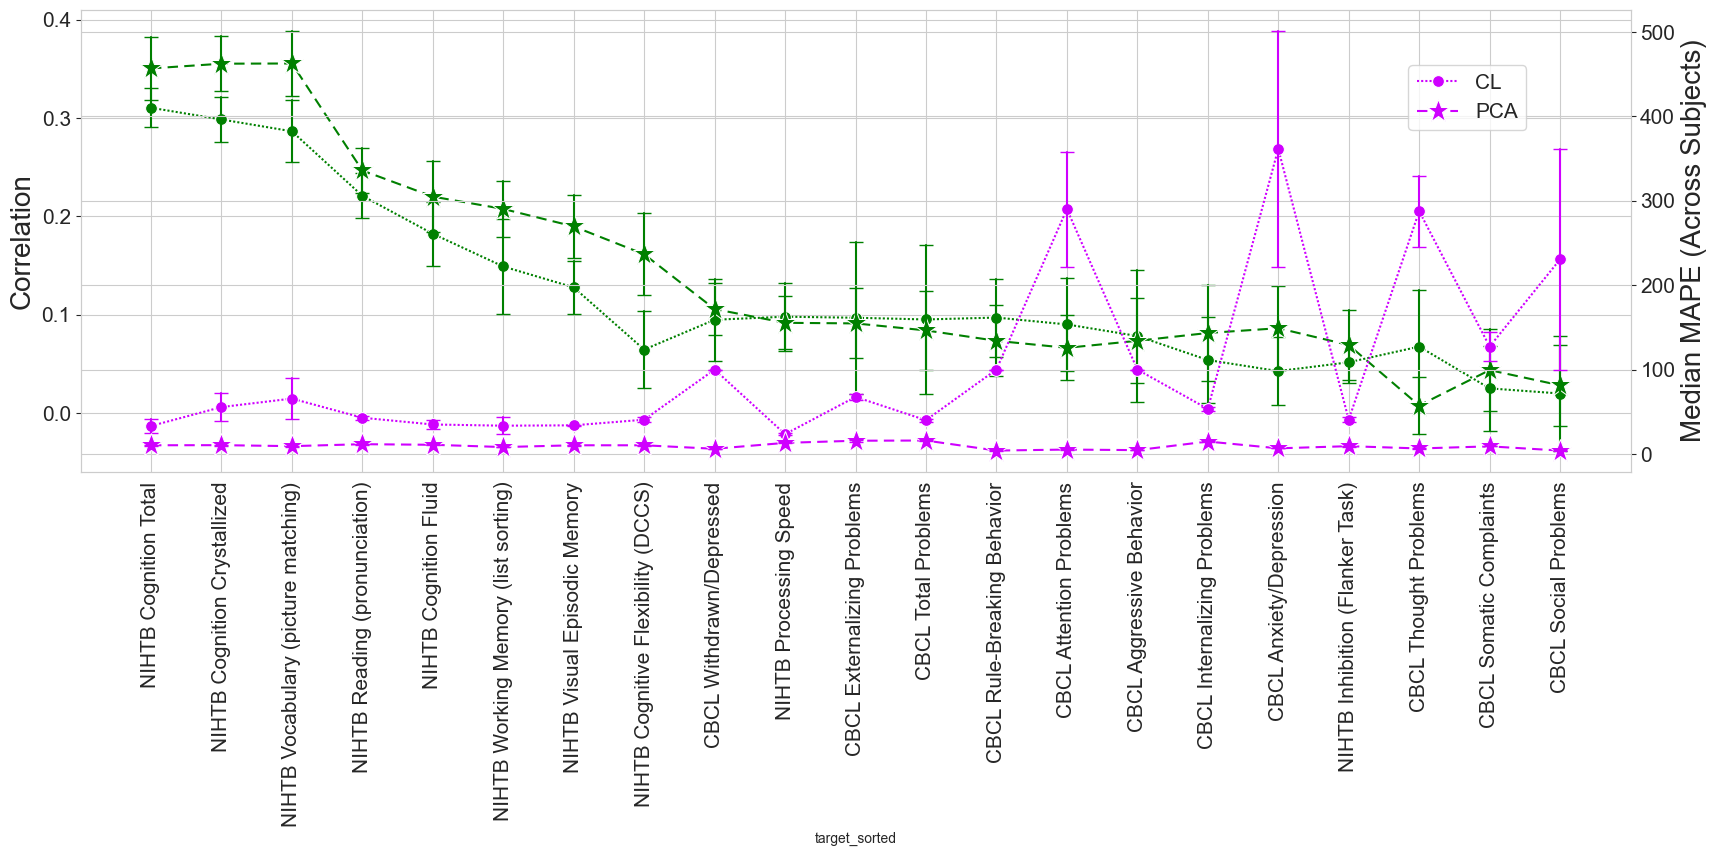

In [35]:
sns.set_style("whitegrid")

markers = {
    "CL": ".",
    "PCA": "*"
}
dashes = {
    'CL': (1, 1),
    'PCA': (5, 3)
    }

fig, ax1 = plt.subplots(figsize=(20, 6))    
ax1 = sns.lineplot(data=perf_df,
                   x="target_sorted",
                   y="test_corr",
                   color="g",
                #    label="Correlation",
                   err_style="bars",
                   style="Feature type",
                   err_kws={'capsize':5},
                   errorbar=("sd", 1),
                   markers=markers,
                   dashes=dashes,
                   markersize=17,
                   legend=False)
plt.xticks(rotation=90, fontsize=15)
ax2 = ax1.twinx()
sns.lineplot(data=perf_df,
             x="target_sorted",
             y="median_test_mape",
             ax=ax2,
             color="#CF00FF",
             err_style="bars",
             style="Feature type",
             errorbar=("sd", 1),
             err_kws={'capsize':5},
             markersize=17,
             markers=markers,
             dashes=dashes,
            #  label="Median MAPE"
             )

ax1.set_ylabel("Correlation", fontsize=20)
ax2.set_ylabel("Median MAPE (Across Subjects)", fontsize=20)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", bbox_to_anchor=(0.85, 0.80, 1., .102), fontsize=15)
plt.savefig(f"figures/cl_vs_pca_pred_perf_{dataset_name}_test.png", dpi=300, bbox_inches='tight', format='png')

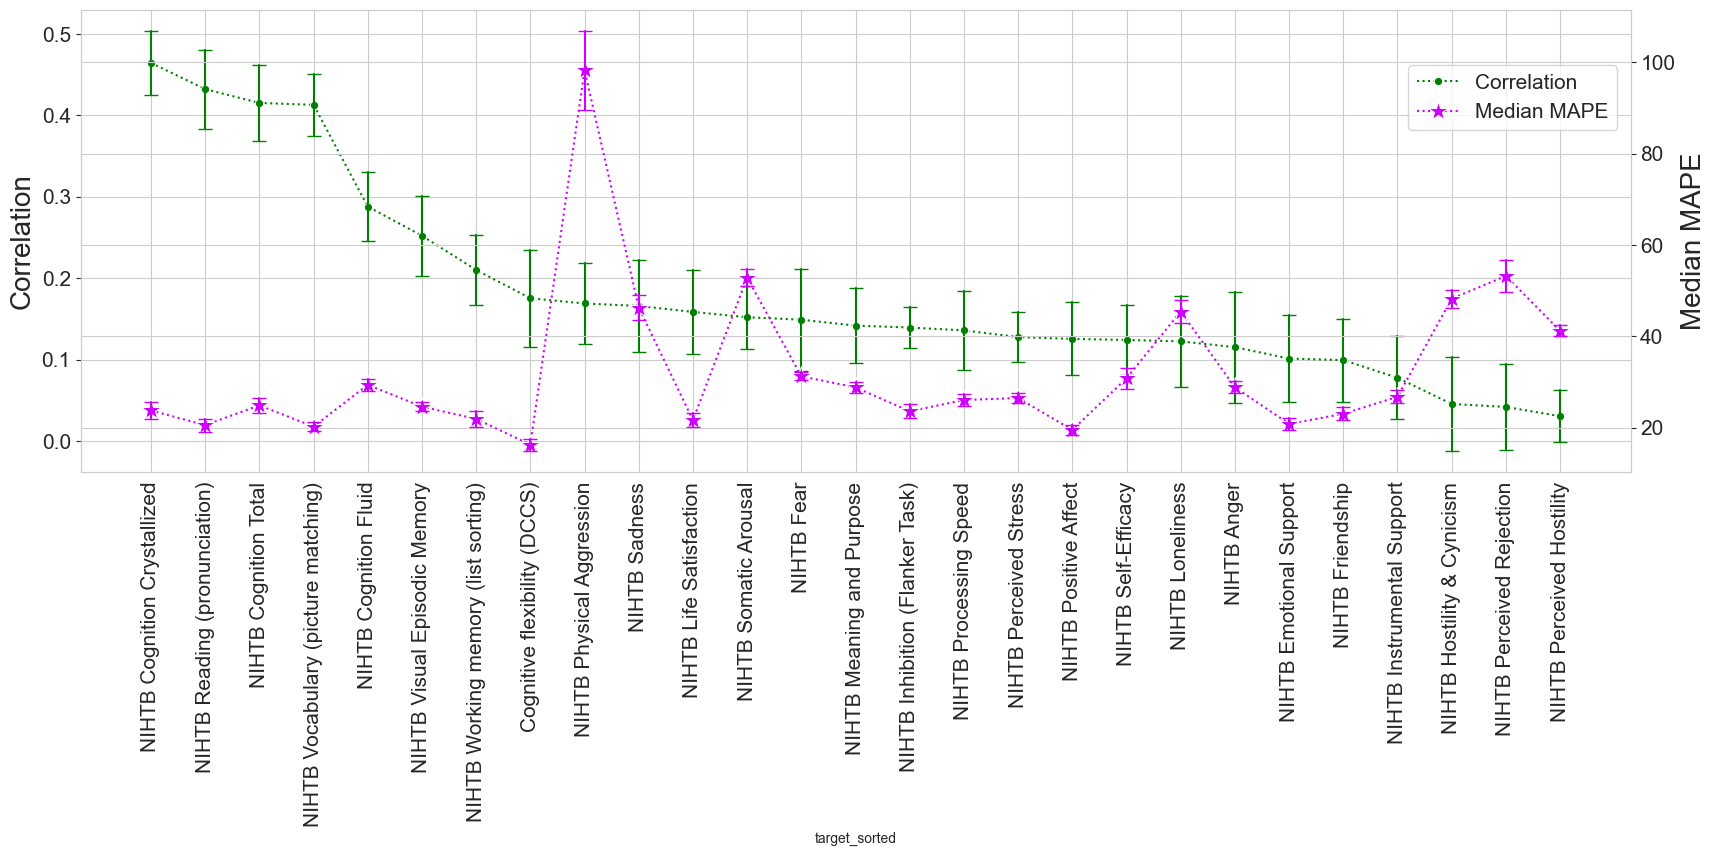

In [41]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(20, 6))    
ax1 = sns.lineplot(data=perf_df,
                   x="target_sorted",
                   y="test_corr",
                   color="g",
                   label="Correlation",
                   err_style="bars",
                   marker="o",
                   err_kws={'capsize':5},
                   errorbar=("sd", 1),
                    linestyle='dotted',
                   legend=False)
plt.xticks(rotation=90, fontsize=15)
ax2 = ax1.twinx()
sns.lineplot(data=perf_df,
             x="target_sorted",
             y="median_test_mape",
             ax=ax2,
             color="#CF00FF",
             err_style="bars",
             marker="*",
             errorbar=("sd", 1),
             err_kws={'capsize':5},
             markersize=15,
             linestyle='dotted',
             label="Median MAPE")

ax1.set_ylabel("Correlation", fontsize=20)
ax2.set_ylabel("Median MAPE", fontsize=20)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", bbox_to_anchor=(0.85, 0.80, 1., .102), fontsize=15)

In [20]:
y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == train_ratio) & (predictions[run_type] == run_id)][target].values
y_test = predictions[(predictions["dataset"] == test_type) & (predictions["train_ratio"] == train_ratio) & (predictions[run_type] == run_id)][target].values

ridge_estimator = Ridge(alpha=1)
fitted_ridge = ridge_estimator.fit(X_train, y_train)
y_train_pred = fitted_ridge.predict(X_train)
y_test_pred = fitted_ridge.predict(X_test)

In [25]:
np.save(f"{exp_dir}/ridge_y_pred_train_{target}_{run_type}_{run_id}.npy", y_train_pred)
np.save(f"{exp_dir}/ridge_y_pred_test_{target}_{run_type}_{run_id}.npy", y_test_pred)

### Baseline: Train on all FC edges

In [70]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])


In [72]:
runs

[1001, 42, 54, 90, 101, 80, 422, 142, 128, 340]

In [160]:
ridge_runs = []

        
for run_id in tqdm(runs):
    print(f"Run {run_id}")
    X_train_idx = np.load(f"{exp_dir}/train_idx_{run_type}{run_id}_train_ratio{train_ratio}.npy")
    X_test_idx = np.load(f"{exp_dir}/test_idx_{run_type}{run_id}_train_ratio{train_ratio}.npy")

    X_train = dataset.isel(index=X_train_idx).matrices.values
    X_train = sym_matrix_to_vec(X_train)

    X_test = dataset.isel(index=X_test_idx).matrices.values
    X_test = sym_matrix_to_vec(X_test)

    for target in tqdm(target_dict.keys()):
        if target in predictions.columns:
            print(f"Target {target}")
            
            target_run_perf = {}
            y_train = dataset[target].values[X_train_idx]
            y_test = dataset[target].values[X_test_idx]


            ridge_fitted = ridge_pipeline.fit(X_train, y_train)
            y_train_pred = ridge_fitted.predict(X_train)
            y_test_pred = ridge_fitted.predict(X_test)

            train_corr = custom_corr(y_train, y_train_pred)
            test_corr = custom_corr(y_test, y_test_pred)

            target_run_perf["target"] = target_dict[target]
            target_run_perf["train_corr"] = train_corr
            target_run_perf["test_corr"] = test_corr
            target_run_perf["median_train_mape"] = np.median(100*np.abs(y_train-y_train_pred)/y_train)
            target_run_perf["median_test_mape"] = np.median(100*np.abs(y_test-y_test_pred)/y_test)
            target_run_perf["train_ratio"] = train_ratio
            target_run_perf[run_type] = run_id

            ridge_runs.append(target_run_perf)
ridge_runs_df = pd.DataFrame(ridge_runs)
ridge_runs_df.to_csv(f"{exp_dir}/baseline_ridge_model_perf_runs.csv", index=False)


  0%|          | 0/10 [00:00<?, ?it/s]

Run 1001


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


 10%|█         | 1/10 [00:26<04:00, 26.69s/it]

Run 42


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


 20%|██        | 2/10 [00:53<03:36, 27.02s/it]

Run 54


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


 30%|███       | 3/10 [01:21<03:11, 27.33s/it]

Run 90


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


 40%|████      | 4/10 [01:49<02:45, 27.63s/it]

Run 101


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


 50%|█████     | 5/10 [02:18<02:19, 27.89s/it]

Run 80


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


 60%|██████    | 6/10 [02:46<01:52, 28.08s/it]

Run 422


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


 70%|███████   | 7/10 [03:16<01:26, 28.85s/it]

Run 142


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


 80%|████████  | 8/10 [03:51<01:01, 30.55s/it]

Run 128


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


 90%|█████████ | 9/10 [04:25<00:31, 31.80s/it]

Run 340


Target cbcl_scr_syn_anxdep_t


Target cbcl_scr_syn_withdep_t


Target cbcl_scr_syn_somatic_t


Target cbcl_scr_syn_social_t


Target cbcl_scr_syn_thought_t


Target cbcl_scr_syn_attention_t


Target cbcl_scr_syn_rulebreak_t


Target cbcl_scr_syn_aggressive_t


Target cbcl_scr_syn_internal_t


Target cbcl_scr_syn_external_t


Target cbcl_scr_syn_totprob_t


100%|██████████| 10/10 [04:59<00:00, 29.93s/it]


In [152]:
ridge_runs_df

,target,train_corr,test_corr,median_train_mape,median_test_mape,train_ratio,seed
0,NIHTB Vocabulary (picture matching),1.0,0.347609,0.000135,9.466767,1.0,1001
1,NIHTB Inhibition (Flanker Task),1.0,0.027197,0.000141,9.240753,1.0,1001
2,NIHTB Working Memory (list sorting),1.0,0.189522,0.000143,9.142415,1.0,1001
3,NIHTB Cognitive Flexibility (DCCS),1.0,0.095046,0.000166,10.221548,1.0,1001
4,NIHTB Processing Speed,1.0,0.118156,0.000218,15.157123,1.0,1001
...,...,...,...,...,...,...,...
95,NIHTB Visual Episodic Memory,1.0,0.120767,0.000161,10.283760,1.0,340
96,NIHTB Reading (pronunciation),1.0,0.244302,0.000180,11.576608,1.0,340
97,NIHTB Cognition Fluid,1.0,0.207006,0.000175,11.633075,1.0,340
98,NIHTB Cognition Crystallized,1.0,0.379237,0.000159,10.523710,1.0,340


In [176]:
dataset_name = "abcd"
exp_name_cog = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_cog"
exp_name_psy = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_psy"
perf_cog = pd.read_csv(f"results/{exp_name_cog}/baseline_ridge_model_perf_runs.csv")
perf_psy = pd.read_csv(f"results/{exp_name_psy}/baseline_ridge_model_perf_runs.csv")

perf_df = pd.concat([perf_cog, perf_psy])
perf_df["median_test_mape"].replace([np.inf, -np.inf], 100, inplace=True)
perf_df["median_train_mape"].replace([np.inf, -np.inf], 100, inplace=True)

mean_perf_df = perf_df.groupby('target')['test_corr'].mean()
sorted_targets = mean_perf_df.sort_values(ascending=False).index
perf_df['target_sorted'] = pd.Categorical(perf_df['target'], categories=sorted_targets)

In [177]:
perf_df[perf_df["target"] == "NIHTB Cognition Crystallized"]["test_corr"].mean()

0.34613936877191376

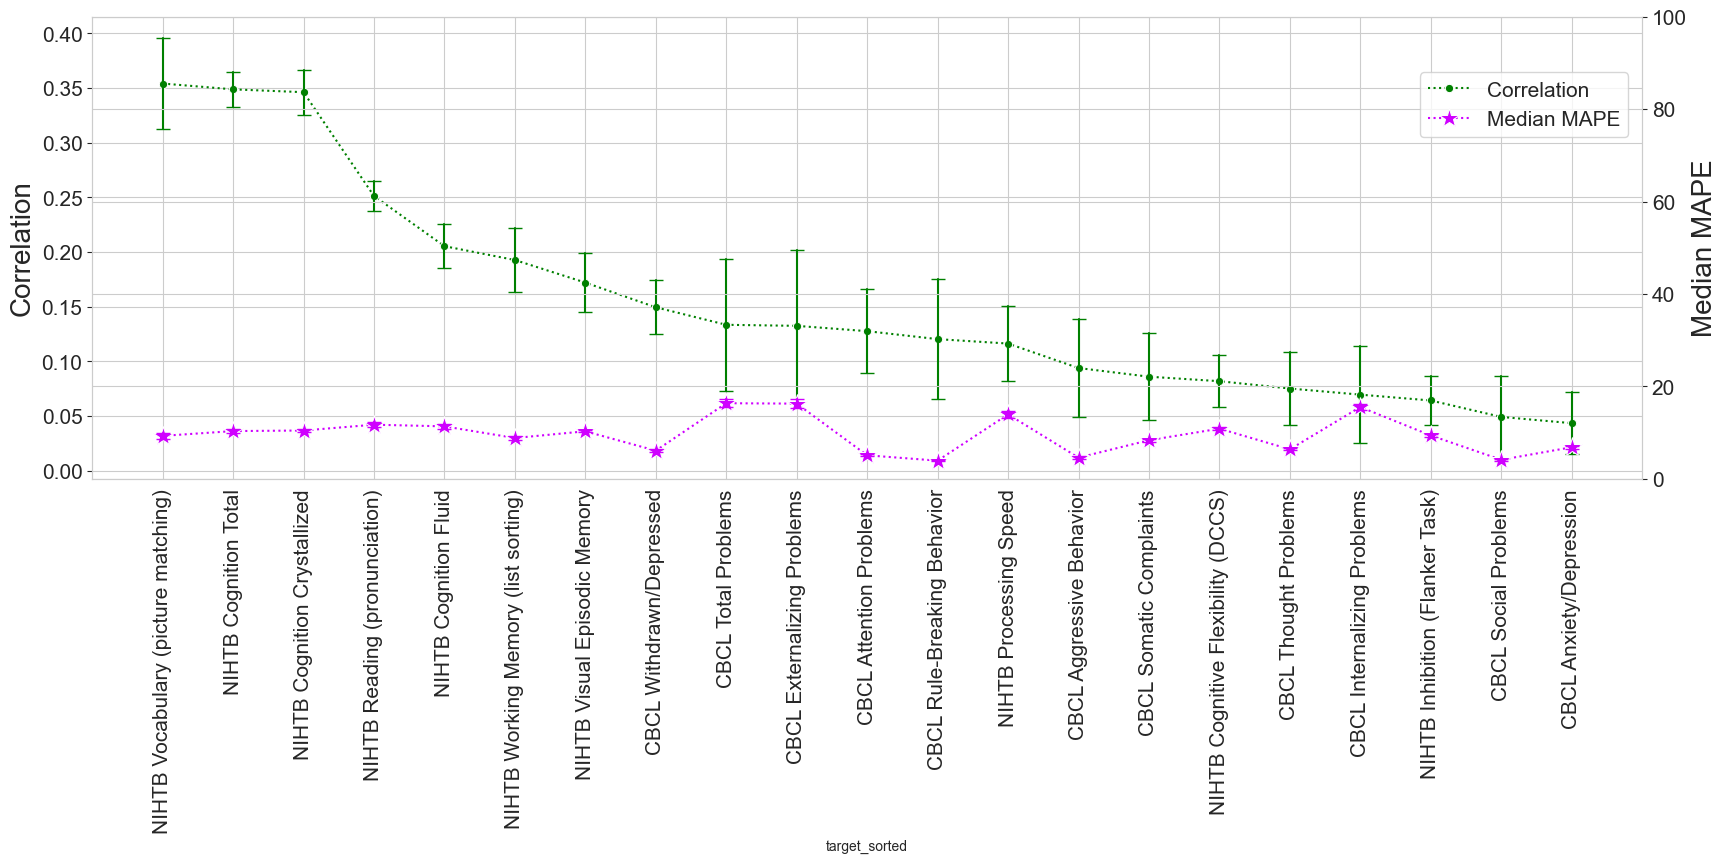

In [178]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(20, 6))    
ax1 = sns.lineplot(data=perf_df,
                   x="target_sorted",
                   y="test_corr",
                   color="g",
                   label="Correlation",
                   err_style="bars",
                   marker="o",
                   err_kws={'capsize':5},
                   errorbar=("sd", 1),
                    linestyle='dotted',
                   legend=False)
plt.xticks(rotation=90, fontsize=15)
ax2 = ax1.twinx()
sns.lineplot(data=perf_df,
             x="target_sorted",
             y="median_test_mape",
             ax=ax2,
             color="#CF00FF",
             err_style="bars",
             marker="*",
             errorbar=("sd", 1),
             err_kws={'capsize':5},
             markersize=15,
             linestyle='dotted',
             label="Median MAPE")

ax1.set_ylabel("Correlation", fontsize=20)
ax2.set_ylabel("Median MAPE", fontsize=20)

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

ax2.set_ylim(0, 100)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", bbox_to_anchor=(0.85, 0.80, 1., .102), fontsize=15)
plt.savefig(f"figures/baseline_ridge_perf_{dataset_name}_test.svg", dpi=300, bbox_inches='tight', format='svg')

In [22]:
custom_corr(y_test, y_test_pred)

0.3756851855291548

In [23]:
custom_corr(y_train, y_train_pred)

0.7829681210685571

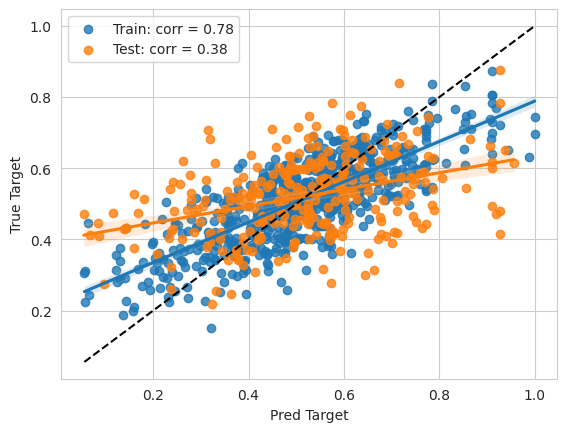

In [24]:
train_corr = custom_corr(y_train, y_train_pred)
test_corr = custom_corr(y_test, y_test_pred)

sns.regplot(x=y_train, y=y_train_pred, label=f"Train: corr = {train_corr:.2f}")
sns.regplot(x=y_test, y=y_test_pred, label=f"Test: corr = {test_corr:.2f}")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], linestyle='--', c='black')
plt.ylabel("True Target")
plt.xlabel("Pred Target")
plt.legend()
plt.show()

Text(0.5, 0, '')

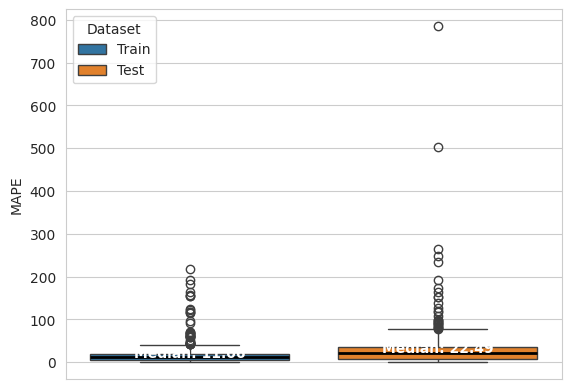

In [129]:
mape_df = pd.DataFrame({
    "sub_id": np.concat([sub_idx_train, sub_idx_test]),
    "dataset": ["Train"]*len(sub_idx_train) + ["Test"]*len(sub_idx_test),
    "MAPE": np.concat([100*np.abs(y_train-y_train_pred)/y_train, 100*np.abs(y_test-y_test_pred)/y_test])
})
median_mape_train = np.median(100*np.abs(y_train-y_train_pred)/y_train)
median_mape_test = np.median(100*np.abs(y_test-y_test_pred)/y_test)

sns.set_style("whitegrid")
sns.boxplot(data=mape_df, x='dataset', y='MAPE', hue='dataset',
            legend=True,
            medianprops={"color": "black", "linewidth": 2}
              )
plt.text(0, median_mape_train + 0.5, f'Median: {median_mape_train:.2f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
plt.text(1, median_mape_test+ 0.5, f'Median: {median_mape_test:.2f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
plt.xticks([], [])
# plt.ylim(-.05, 1.05)
plt.legend(title='Dataset', loc='upper left')
plt.xlabel('Value')
plt.xlabel('')


Text(0.5, 1.0, 'MAPE Test')

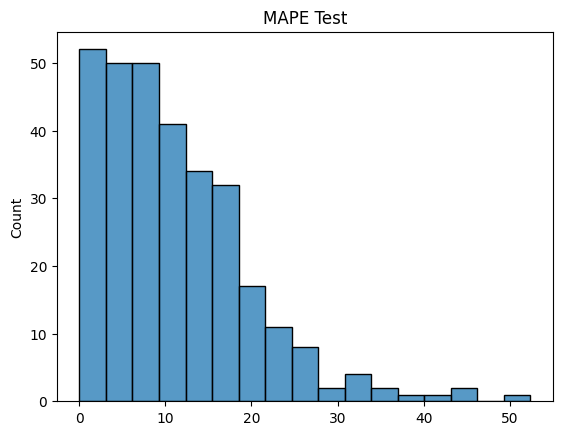

In [184]:
sns.histplot(x=100*np.abs(y_test-y_test_pred)/y_test)
plt.title("MAPE Test")

<Axes: xlabel='Mean of x and y', ylabel='x - y'>

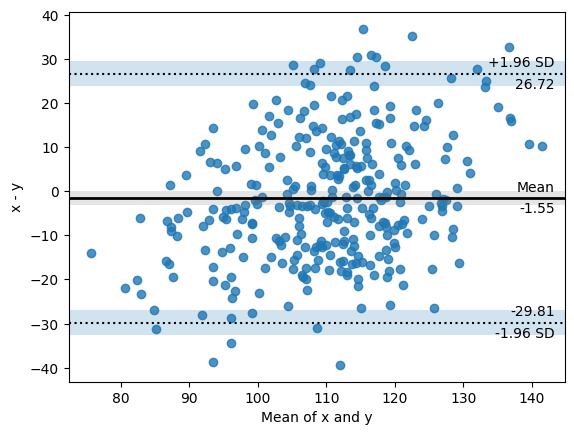

In [185]:
pg.plot_blandaltman(y_test, y_test_pred)